In [23]:
from setup_notebook import setup_project_path
setup_project_path()

In [24]:
from src.config import RAW_DATA_DIR, PROCESSED_DATA_DIR, MODELS_DIR

In [25]:
import subprocess
import sys
import joblib
from sklearn.model_selection import RepeatedKFold, KFold, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error
import lightgbm
from lightgbm import LGBMRegressor
import pandas as pd
import argparse
from datetime import datetime, date, timedelta
from dateutil.relativedelta import relativedelta
import numpy as np
import boto3
import gc
import datetime as dt
import io
from io import StringIO
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
data_dir = PROCESSED_DATA_DIR
model_dir = MODELS_DIR

os.makedirs(data_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In [27]:
def generate_predictions(features_file):
    df_KPI = pd.read_csv(features_file)
    df_KPI = df_KPI[df_KPI.backtesting_limit>=360]
    # print(df_KPI.shape)

    model = lightgbm.Booster(model_file = os.path.join(model_dir,'lgbm_cbr_model_2025-09-23.txt'))

    cols_with_prefix = ['frr', 'repayment_speed', 'avg_cum_days_disabled',
                    'at_risk_rate', 'disabled_gt_two_week_rate', 'unlocked_rate', 'disabled_rate']

    df_long = (pd.wide_to_long(
        df_KPI,
        stubnames=cols_with_prefix,
        i=["accounts_group", "reg_month", "country", "product_group", "area", "primary_product"],
        j="backtesting",
        sep="_",
        suffix=r"\d+"
    ).reset_index()
    .dropna(subset=cols_with_prefix)
    )

    df_long = df_long[df_long.backtesting>=360].sample(frac=1)

    X = df_long[["avg_planned_repayment_days", "backtesting", "frr", "repayment_speed", \
                "avg_cum_days_disabled", "at_risk_rate", "disabled_gt_two_week_rate", "unlocked_rate", "disabled_rate", \
                    "avg_upfront_price_usd", "avg_unlock_price_usd"]]
    print(X.shape)

    y_pred = model.predict(X)

    df_long_copy = df_long.copy()
    df_long_copy['predicted_frr'] = y_pred
    df_long_copy['predicted_revenue_USD'] = np.round(df_long_copy['predicted_frr']*df_long_copy['total_follow_on_revenue_usd'],2)
    return df_long_copy



In [28]:
df_long_copy_sep = generate_predictions(features_file='../data/KPIs_data_processed_2025-09-01.csv')
df_long_copy_sep["date_uploaded"] = '2025-09-01'

df_long_copy_aug = generate_predictions(features_file='../data/KPIs_data_processed_2025-08-01.csv')
df_long_copy_aug["date_uploaded"] = '2025-08-01'

(730194, 11)
(710374, 11)


In [39]:
df_long_copy_sep = df_long_copy_sep[df_long_copy_sep.backtesting==df_long_copy_sep.cohort_age_backtesting]
df_long_copy_aug = df_long_copy_aug[df_long_copy_aug.backtesting==df_long_copy_aug.cohort_age_backtesting]

In [43]:
df_long_copy_sep[df_long_copy_sep['accounts_group']=='2024-07_Kenya_Lanterns_Kakamega_Sun King Pro EasyBuy']

,accounts_group,reg_month,country,product_group,area,primary_product,backtesting,age_in_months,avg_planned_repayment_days,avg_unlock_price_usd,...,frr,repayment_speed,avg_cum_days_disabled,at_risk_rate,disabled_gt_two_week_rate,unlocked_rate,disabled_rate,predicted_frr,predicted_revenue_USD,date_uploaded
1602025,2024-07_Kenya_Lanterns_Kakamega_Sun King Pro E...,2024-07,Kenya,Lanterns,Kakamega,Sun King Pro EasyBuy,360,13,405,49.0,...,0.537252,0.6105,128.0,0.0,0.130435,0.014493,0.42029,0.882094,2833.35,2025-09-01


In [44]:
df_long_copy_aug[df_long_copy_aug['accounts_group']=='2024-07_Kenya_Lanterns_Kakamega_Sun King Pro EasyBuy']

,accounts_group,reg_month,country,product_group,area,primary_product,backtesting,age_in_months,avg_planned_repayment_days,avg_unlock_price_usd,...,frr,repayment_speed,avg_cum_days_disabled,at_risk_rate,disabled_gt_two_week_rate,unlocked_rate,disabled_rate,predicted_frr,predicted_revenue_USD,date_uploaded
1599205,2024-07_Kenya_Lanterns_Kakamega_Sun King Pro E...,2024-07,Kenya,Lanterns,Kakamega,Sun King Pro EasyBuy,360,12,405,49.0,...,0.537252,0.6105,128.0,0.0,0.130435,0.014493,0.42029,0.882094,2833.35,2025-08-01


In [40]:
# df_truth = pd.read_csv("../data/processed/truths_1080.csv")
# df_truth.head()
# df_long_copy_sep = pd.merge(left=df_long_copy_sep, right=df_truth, on="accounts_group")

In [41]:
# df_long_copy = pd.concat([df_long_copy_sep, df_long_copy_aug])

# df_long_copy["date_uploaded"] = pd.to_datetime(df_long_copy["date_uploaded"], format="%Y-%m-%d")
# df_long_copy["reg_month"] = pd.to_datetime(df_long_copy["reg_month"], format="%Y-%m")

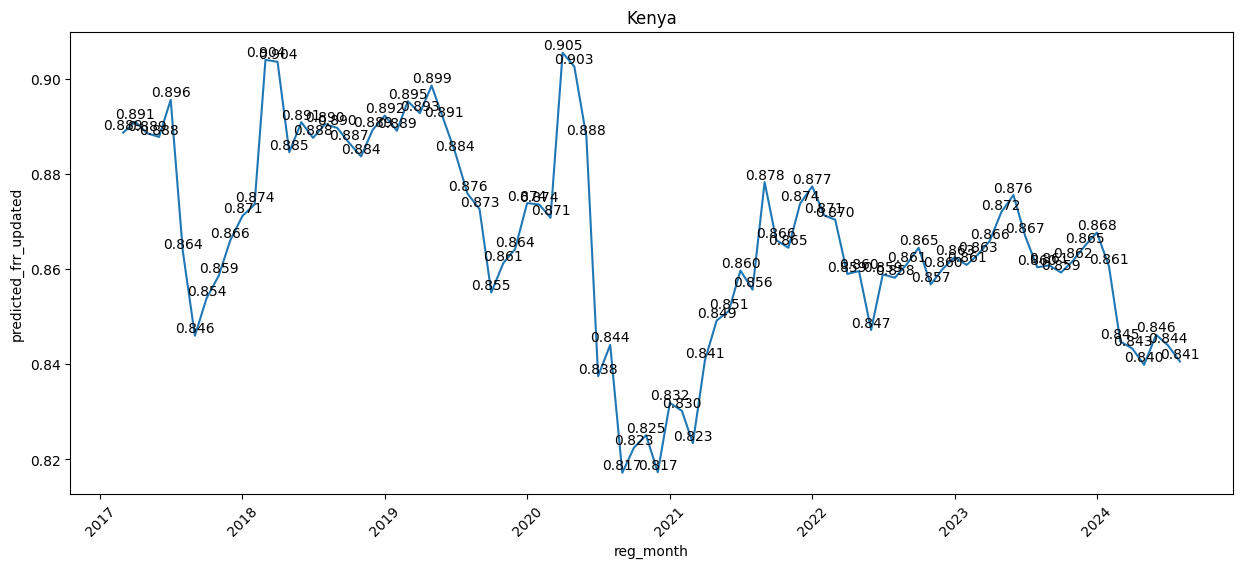

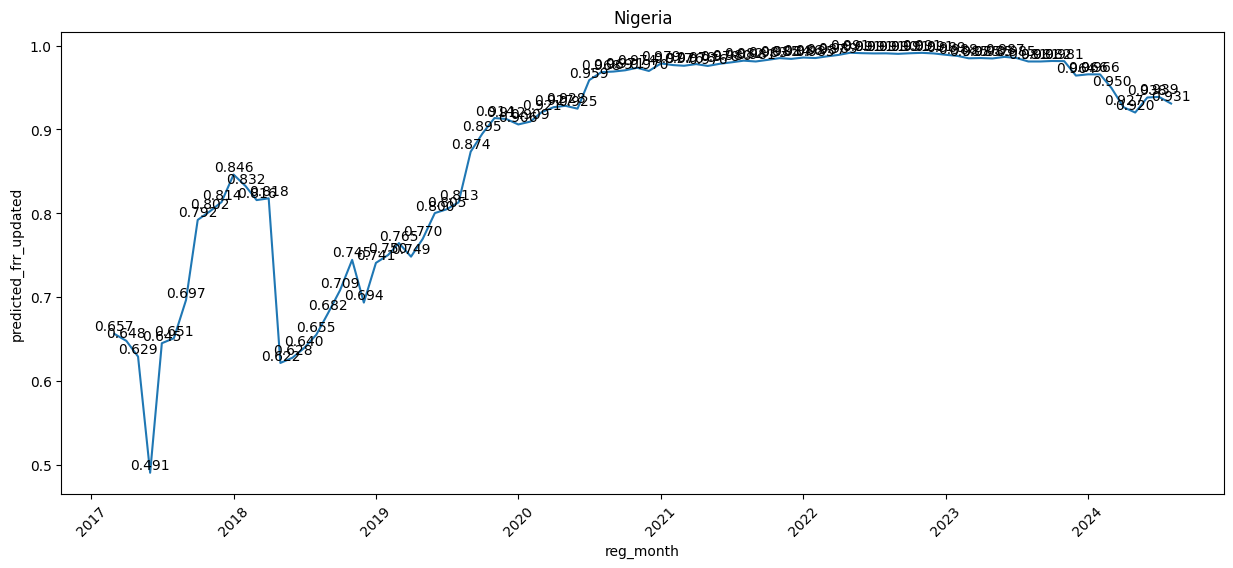

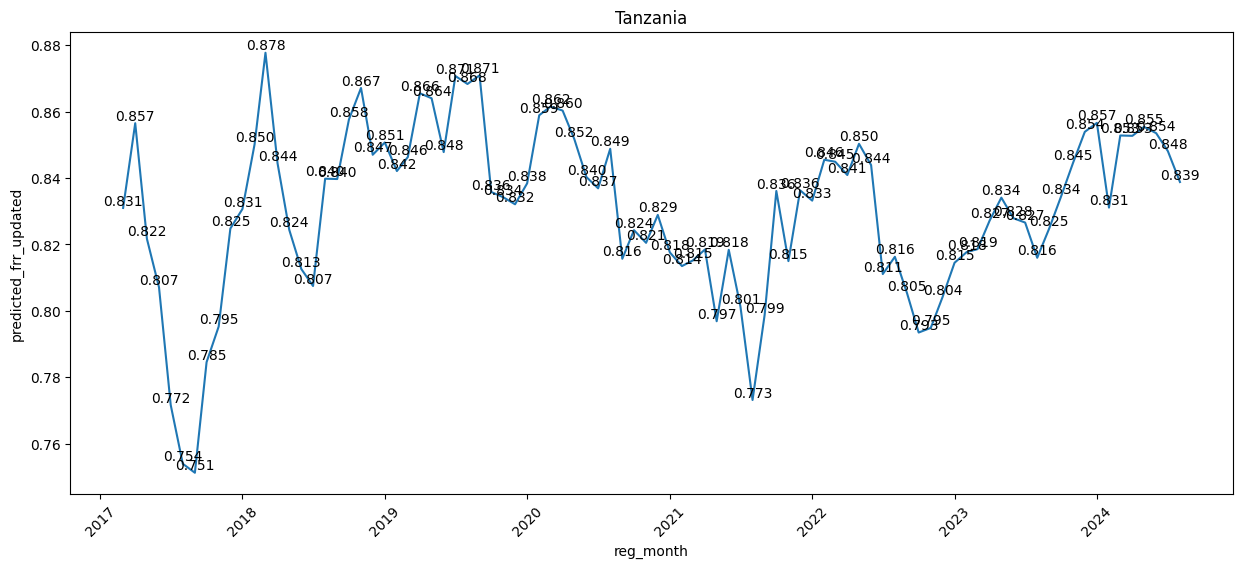

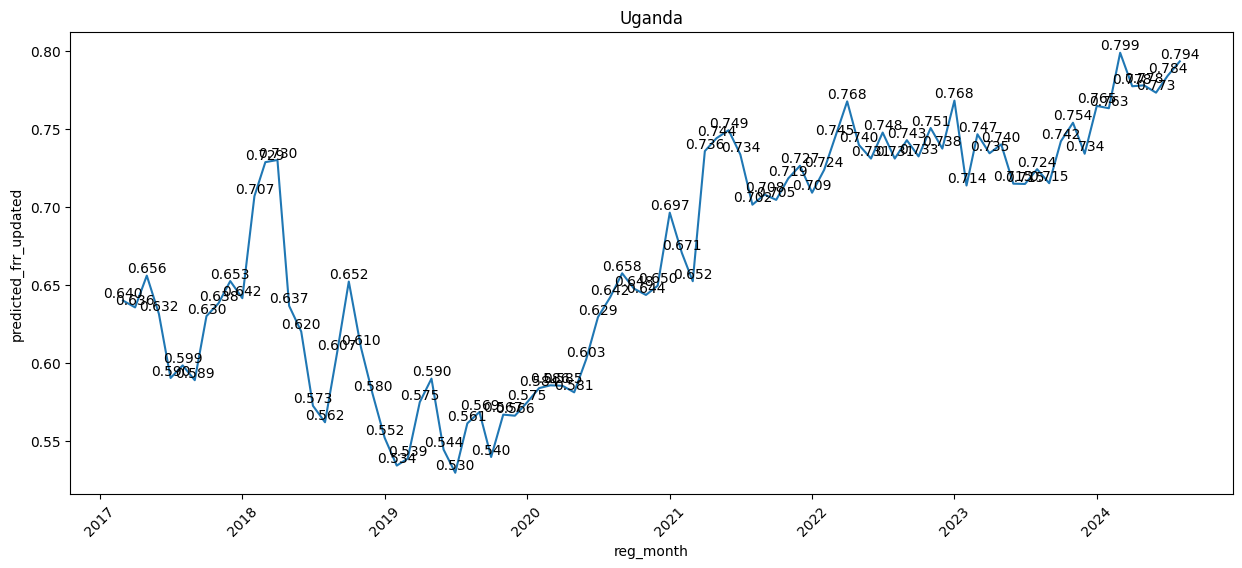

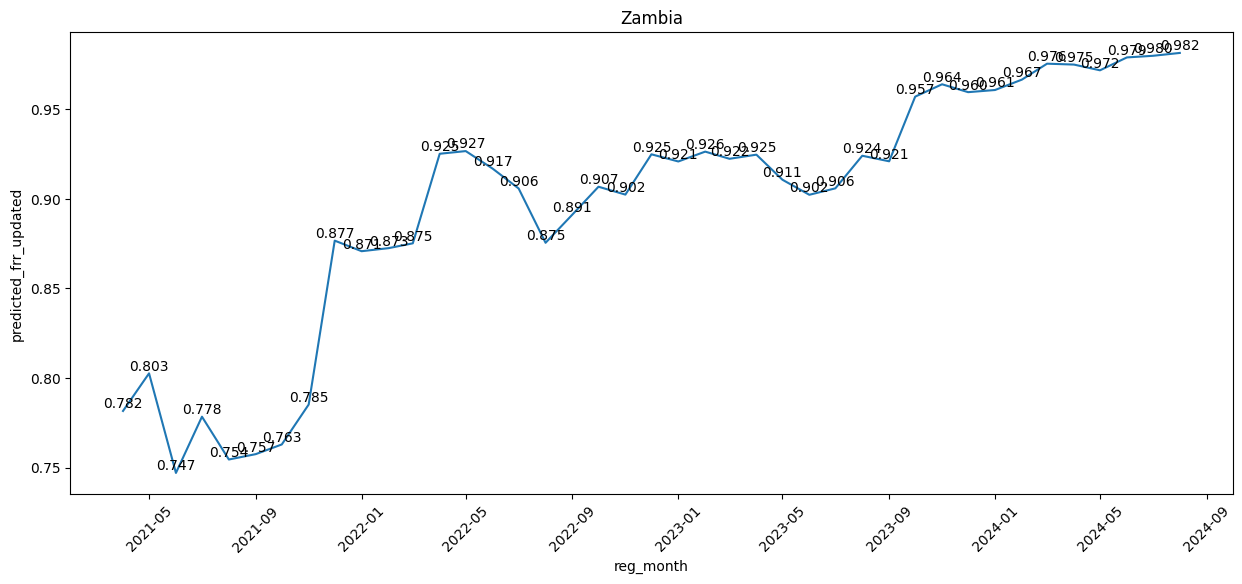

In [45]:
df_country = df_long_copy_sep.groupby(["reg_month", "country", 'backtesting', "date_uploaded"]).agg(
    total_follow_on_price=('total_follow_on_revenue_usd', "sum"),
    total_predicted_fr=('predicted_revenue_USD', 'sum')
).reset_index()
df_country["predicted_frr_updated"] = np.round(df_country.total_predicted_fr/df_country.total_follow_on_price,4)
df_country["reg_month"] = pd.to_datetime(df_country["reg_month"], format="%Y-%m")
for country in ['Kenya','Nigeria','Tanzania','Uganda','Zambia']:
    plt.figure(figsize=(15, 6))
    subset = df_country[(df_country.country==country) & (df_country.reg_month>="2017-03-01")]
    ax = sns.lineplot(data=subset, x="reg_month", y="predicted_frr_updated")
    for x, y in zip(subset["reg_month"], subset["predicted_frr_updated"]):
        ax.text(x, y, f"{y:.3f}", ha="center", va="bottom")
    # sns.lineplot(data=df2, x="reg_month", y="frr_prediction_50")
    plt.xticks(rotation=45)
    plt.title(country)
    plt.show()

In [ ]:
subset

,reg_month,country,backtesting,date_uploaded,total_follow_on_price,total_predicted_fr,predicted_frr_updated
98,2017-03-01,Kenya,630,2025-09-01,3.257949e+05,289153.67,0.8875
123,2017-04-01,Kenya,630,2025-09-01,3.229304e+05,287930.50,0.8916
148,2017-05-01,Kenya,630,2025-09-01,2.927579e+05,259609.60,0.8868
173,2017-06-01,Kenya,630,2025-09-01,3.815004e+05,338896.58,0.8883
198,2017-07-01,Kenya,630,2025-09-01,4.724717e+05,423397.31,0.8961
...,...,...,...,...,...,...,...
2159,2022-06-01,Kenya,630,2025-09-01,1.265773e+07,10719952.07,0.8469
2204,2022-07-01,Kenya,630,2025-09-01,1.329767e+07,11418569.01,0.8587
2249,2022-08-01,Kenya,630,2025-09-01,1.327313e+07,11395519.93,0.8585
2294,2022-09-01,Kenya,630,2025-09-01,1.177126e+07,10090926.85,0.8573
